# Librerias

In [21]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import MSTL
from datetime import datetime
import pickle

import matplotlib.pyplot as plt
import seaborn as sbn
from datetime import datetime

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_privacy

from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import load_model

# Abrir Datos

In [2]:
seno = pd.read_excel("Seno_freq_30_amplitud_10_ruido3.xlsx")

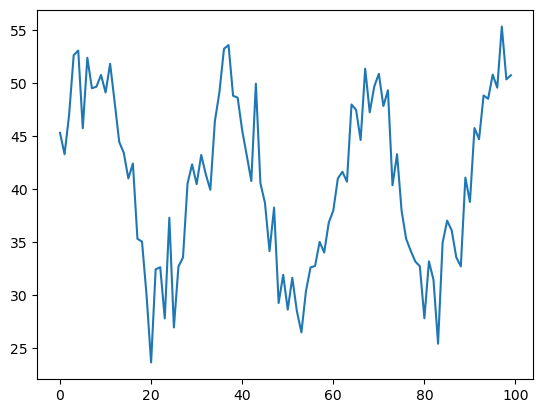

In [3]:
plt.plot(seno[:100])

# Crear Funciones

## LSTM

In [39]:
def LSTM_JD(datos,ventana,prediccion,fechas,nodos1,nodos2,paciencia,epocas,batch,activacion1,activacion2,activacion3,size_test,size_val,nombre):

    

    datos = datos.values.reshape(-1, 1)

    estandarizacion = MinMaxScaler().fit(datos)
    scaled_data = estandarizacion.transform(datos)


    # dividir en train, test
    X, y = [], []
    Xf,yf = [],[]
    
    for i in range(len(scaled_data) - ventana - prediccion):
        X.append(scaled_data[i:i+ventana])
        y.append(scaled_data[i+ventana:i+ventana+prediccion])

        Xf.append(fechas[i:i+ventana])
        yf.append(fechas[i+ventana:i+ventana+prediccion])

    X, y = np.array(X), np.array(y)
    Xf,yf = np.array(Xf),np.array(yf)



    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size_test, shuffle=False)

    fecha_X_train, fecha_X_test, fecha_y_train, fecha_y_test = train_test_split(Xf, yf, test_size=size_test, shuffle=False)


    model = Sequential()

    model.add(LSTM(nodos1,activation= activacion1, input_shape=(ventana,1)))
    model.add(Dense(nodos2, activation=activacion2))
    model.add(Dense(prediccion , activation=activacion3))


    model.compile(optimizer="Adam", loss='mse')
    early_stopping = EarlyStopping(monitor='loss', patience=paciencia, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=epocas,validation_split = size_val, verbose=1, batch_size=batch,shuffle = False, callbacks=[early_stopping])

    # guardar history.



    # Guardar history usando pickle
    with open(f'{nombre}_history_nodos1_{nodos1}_nodos2_{nodos2}_epocas_{epocas}_batch_{batch}_{activacion1[0]}_{activacion2[0]}_{activacion3[0]}vent{ventana}.pkl', 'wb') as file:
        pickle.dump(history.history, file)


    # guardar los archivo a usar en la carpeta 
    rutaAGuardar = f'{nombre}_Modelo_{nodos1}_nodos1_{nodos2}_nodos2_{epocas}_Epocas_{batch}_Batch_{activacion1[0]}_{activacion2[0]}_{activacion3[0]}vent{ventana}.keras'
    


    model.save(rutaAGuardar)



        
    y_hat = model.predict(X_test, verbose=1)
    y_hat = estandarizacion.inverse_transform(y_hat)

    y_test1 = y_test.reshape(-1, 1)

    y_test1 = estandarizacion.inverse_transform(y_test1)

    y_test1 = y_test1.reshape(-1,prediccion,1)


    return y_hat,y_test1,fecha_y_test, history

## Métricas

In [5]:
def Metricas_Jd(y_hat,y_test,prediccion):
    
    predicciones_porHora_LSTM = []
    reales_porHora_LSTM = []
    for i in range(prediccion):
            
        pred = []
        for Predicciones in y_hat:
            pred.append(Predicciones[i])
            
        real = []
        for reales in y_test:
            real.append(reales[i])
            
        predicciones_porHora_LSTM.append(pred)
        reales_porHora_LSTM.append(real)
        

    MAES_LSTM = {}
    RMSE_LSTM = {}
    ER_Medios_LSTM = {}
    ER_Medianos_LSTM = {}
    epsilon_LSTM = 1e-10
    for i in range(prediccion):
        MAE_LSTM = round(mean_absolute_error(predicciones_porHora_LSTM[i],reales_porHora_LSTM[i]),2)
        MSE_LSTM = round(mean_squared_error(reales_porHora_LSTM[0],predicciones_porHora_LSTM[i]),2)
        Error_Relativo_Medio_LSTM = round((np.mean(np.abs((np.array(reales_porHora_LSTM[i]) - np.array(predicciones_porHora_LSTM[i])) / (np.array(reales_porHora_LSTM[i])+epsilon_LSTM)))*100),2)
        Error_Relativo_Mediano_LSTM = round((np.median(np.abs((np.array(reales_porHora_LSTM[i]) - np.array(predicciones_porHora_LSTM[i])) / (np.array(reales_porHora_LSTM[i])+epsilon_LSTM)))*100),2)
        
        
        MAES_LSTM[i] = MAE_LSTM
        RMSE_LSTM[i] = round(np.sqrt(MSE_LSTM),2)
        ER_Medianos_LSTM[i] = Error_Relativo_Mediano_LSTM
        ER_Medios_LSTM[i] = Error_Relativo_Medio_LSTM
        
    return MAES_LSTM,RMSE_LSTM,ER_Medianos_LSTM,ER_Medios_LSTM

## Abrir Modelo

In [6]:


def Abrir_Modelo(datos,fechas,modelo,ventana,prediccion,size_test):
        


    datos = datos.values.reshape(-1, 1)

    estandarizacion = MinMaxScaler().fit(datos)
    scaled_data = estandarizacion.transform(datos)


    # dividir en train, test
    X, y = [], []
    Xf,yf = [],[]

    for i in range(len(scaled_data) - ventana - prediccion):
        X.append(scaled_data[i:i+ventana])
        y.append(scaled_data[i+ventana:i+ventana+prediccion])

        Xf.append(fechas[i:i+ventana])
        yf.append(fechas[i+ventana:i+ventana+prediccion])

    X, y = np.array(X), np.array(y)
    Xf,yf = np.array(Xf),np.array(yf)



    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size_test, shuffle=False)

    fecha_X_train, fecha_X_test, fecha_y_train, fecha_y_test = train_test_split(Xf, yf, test_size=size_test, shuffle=False)


        
    y_hat = modelo.predict(X_test, verbose=1)
    y_hat = estandarizacion.inverse_transform(y_hat)

    y_test1 = y_test.reshape(-1, 1)

    y_test1 = estandarizacion.inverse_transform(y_test1)

    y_test1 = y_test1.reshape(-1,prediccion,1)


    return y_hat, y_test1,fecha_y_test,prediccion


# Correr Modelos

In [44]:
# Parámetros

datos = seno['valor']
ventana = 120
prediccion = 30
fechas = datos.index
nodos1 = 150
nodos2 = 150
paciencia = 10
epocas = [10,20,30,40,50,60,70,80,90,99]
activacion1 = "tanh"
activacion2 = "relu"
activacion3 = "linear"
batch = 40
size_test = 0.2
#nombre = "Seno_freq_30_amplitud_10_ruido3 Sin ruido"
nombre = "Seno_freq_30_amplitud_10_ruido3"
size_val = 0.2


In [45]:

for epo in epocas:
    y_hat,y_test1,fecha_y_test, history = LSTM_JD(datos,ventana,prediccion,fechas,nodos1,nodos2,paciencia,epo,batch,activacion1,activacion2,activacion3,size_test,size_val,f"{nombre} Sin ruido")

Epoch 1/10
14/14 [==============================] - 3s 96ms/step - loss: 0.1827 - val_loss: 0.0718
Epoch 2/10
14/14 [==============================] - 1s 70ms/step - loss: 0.0589 - val_loss: 0.0511
Epoch 3/10
14/14 [==============================] - 1s 76ms/step - loss: 0.0501 - val_loss: 0.0473
Epoch 4/10
14/14 [==============================] - 1s 60ms/step - loss: 0.0462 - val_loss: 0.0433
Epoch 5/10
14/14 [==============================] - 1s 71ms/step - loss: 0.0404 - val_loss: 0.0337
Epoch 6/10
14/14 [==============================] - 1s 64ms/step - loss: 0.0262 - val_loss: 0.0179
Epoch 7/10
14/14 [==============================] - 1s 67ms/step - loss: 0.0133 - val_loss: 0.0101
Epoch 8/10
14/14 [==============================] - 1s 75ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 9/10
14/14 [==============================] - 1s 80ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 10/10
6/6 [==============================] - 1s 31ms/step
Epoch 1/20
14/14 [===========================